# PREDICCIÓN CHURN POR NODO

## CONTENIDO

* Carga de librerías
 * Configuraciones ambiente de trabajo
* 

## Carga de librerías

In [2]:
import sklearn as sk
print(sk.__version__)

1.0.1


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from pmdarima.arima import auto_arima
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error,  mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.api as sm


In [4]:
import sys
print(sys.version)

3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]


### Configuraciones ambiente de trabajo

In [5]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
#pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [152]:
TablaMarClient= pd.read_csv(f'Contact_Cuenta.csv',sep=';')

In [153]:
TablaMarClient.head(2)

,REGIONAL,Distrito,NODO,MARCACIONES,CLIENTES,CONTACT,MES,ANIO,DIA,FECHA1,FECHA
0,REGION CENTRO,SUBAZAR,10,4.000,86,4.651,1,2020,1,1/01/2020,2020-01-01
1,REGION CENTRO,BOLIVIA,11,3.000,75,4.000,1,2020,1,1/01/2020,2020-01-01


In [154]:
len(TablaMarClient)

321874

In [155]:
#carga de los datos
#encoding='ISO-8859-1'
TablaChurn=pd.read_csv(f'Churn_Cuenta.csv',sep=';',decimal='.')

In [156]:
len(TablaChurn)

321874

In [157]:
TablaChurn.head(3)

,Regional,E_distrito,Nodo,Fecha,Value,fecha2
0,REGION CENTRO,SUBAZAR,10,1/01/2020,0.000,2020-01-01
1,REGION CENTRO,BOLIVIA,11,1/01/2020,0.000,2020-01-01
2,REGION CENTRO,BOLIVIA,12,1/01/2020,0.000,2020-01-01


In [158]:
TablaFinal=TablaChurn.merge(TablaMarClient,left_on=['Nodo','fecha2'],right_on=['NODO','FECHA'], how='left')

In [159]:
TablaFinal[TablaFinal['NODO'].isnull()].head(10)

,Regional,E_distrito,Nodo,Fecha,Value,fecha2,REGIONAL,Distrito,NODO,MARCACIONES,CLIENTES,CONTACT,MES,ANIO,DIA,FECHA1,FECHA


In [160]:
Reg_Churn_NoenContact=TablaFinal[TablaFinal['NODO'].isnull()]
Reg_Churn_NoenContact.to_csv('Reg_Churn_NoenContact.csv')

In [161]:
len(TablaFinal)

321874

In [162]:
TablaFinal.drop(columns=['Fecha','ANIO','MES','DIA','FECHA1','FECHA','NODO','REGIONAL','Distrito',], inplace=True)

In [163]:
TablaFinal.sample(10)

,Regional,E_distrito,Nodo,Value,fecha2,MARCACIONES,CLIENTES,CONTACT
17175,REGION NOROCCIDENTE,METROPOLITANA ENVIGADO,AY4,0.000,2020-02-01,1.000,31,3.226
154108,REGION COSTA,BARRANQUILLA 2 DISTRITO 2,OAS,-0.699,2020-12-01,7.000,143,4.895
19492,REGION CENTRO,FACATATIVA,F3A,0.000,2020-02-01,27.000,387,6.977
184623,REGION OCCIDENTE,NARINO 4,VTZ,-0.593,2021-02-01,10.000,337,2.967
43605,REGION ORIENTE,PIEDECUESTA,BGG,0.000,2020-04-01,5.000,84,5.952
91432,REGION ORIENTE,ACACIAS NORTE,YAC,0.000,2020-07-01,12.000,121,9.917
295264,REGION CENTRO,JAVERIANA,2CA11M,0.000,2021-11-01,2.000,22,9.091
118903,REGION CENTRO,LAGO,2C2031,-2.362,2020-10-01,7.000,127,5.512
125701,REGION CENTRO,FERROCARRIL,JAC,-1.754,2020-10-01,28.000,342,8.187
2687,REGION CENTRO,CEDRITOS,5AE024,0.000,2020-01-01,8.000,116,6.897


In [164]:
# colocar la fecha como index
TablaFinal.set_index('fecha2',inplace=True)

In [165]:
TablaFinal.index=pd.to_datetime(TablaFinal.index)

In [166]:
TablaFinal['MARCACIONES'].fillna(0,inplace=True)

In [21]:
#TablaFinal['Value'].fillna(0,inplace=True)

In [22]:
#Inicio de validación 

#### Identificación y corrección de positivos

In [167]:
TablaFinal['pos']=np.where(TablaFinal['Value']>0,1,0)

In [168]:
TablaFinal['Value'].describe()

count   321874.000
mean        -1.045
std          2.152
min       -600.000
25%         -1.596
50%         -0.676
75%          0.000
max          0.000
Name: Value, dtype: float64

In [25]:
#TablaFinalC['CONTACT'].describe()

In [26]:
#TablaFinal[TablaFinal['pos']==1].sample(5)

In [169]:
#num reg con positivos
TablaFinal['pos'].value_counts()/len(TablaFinal)

0   1.000
Name: pos, dtype: float64

In [28]:
#TablaFinal[TablaFinal['pos']==1]['Nodo'].nunique()

In [29]:
#Reemplazar positivos por cero
#TablaFinal['Value']=np.where(TablaFinal['Value']>0,0,TablaFinal['Value'])

## Construcción de Maestro Nodos

In [170]:
maestroNodo=TablaFinal[['Nodo','E_distrito','Regional']]

In [171]:
# sorting by first name
maestroNodo.sort_index(ascending=True, inplace = True)
 
# dropping ALL duplicate values
maestroNodo.drop_duplicates(subset =["Nodo"], keep = 'last', inplace = True)

In [172]:
maestroNodo.head(3)

,Nodo,E_distrito,Regional
fecha2,,,
2020-01-01,PDV,PEREIRA5,REGION NOROCCIDENTE
2020-02-01,AS34A,NaN,NaN
2020-03-01,IAB,NaN,NaN


In [33]:
maestroNodo[maestroNodo['Nodo']=='0C1']

,Nodo,E_distrito,Regional
fecha2,,,
2021-12-01,0C1,CALI NORTE DISTRITO 4,REGION OCCIDENTE


##  Separación Entrenamiento y testing

In [173]:
fechaMaxima=max(TablaFinal.index)
fechaMaxima

Timestamp('2021-12-01 00:00:00')

In [174]:
TablaFinal.index.unique()[-4]

Timestamp('2021-09-01 00:00:00')

In [175]:
fechaTrain=TablaFinal.index.unique()[-4]
fechaTest=TablaFinal.index.unique()[-3]

In [176]:
print (fechaTrain,fechaTest)

2021-09-01 00:00:00 2021-10-01 00:00:00


## Seleccion de Nodos
* Nodos con información en los últimos 3 meses
* Nodos con más de 7 registros (por entrenamiento y pruebas)

In [177]:
len(TablaFinal[TablaFinal.index>='2021-01-01'])

163881

In [178]:
# Nodos con información en los últimos 3 meses
Resumen=TablaFinal[TablaFinal.index>='2021-01-01'].reset_index()[['fecha2','Nodo']].groupby('Nodo').agg(['max','count'])

In [179]:
Resumen.head(2)

fecha2      
            max count
Nodo                 
01J  2021-12-01    12
01S  2021-12-01    12

In [180]:
Resumen.columns = Resumen.columns.droplevel(0)

In [181]:
Resumen['max'].value_counts()

2021-12-01    13812
2021-11-01       20
2021-01-01       19
2021-09-01       12
2021-08-01        5
2021-04-01        5
2021-07-01        3
2021-06-01        3
2021-02-01        3
2021-05-01        2
2021-10-01        1
Name: max, dtype: int64

In [182]:
Resumen['sel']=np.where(Resumen['max']<=fechaTest,'sinInfoReciente','nodoValido')

In [183]:
Resumen['sel'].value_counts()

nodoValido         13832
sinInfoReciente       53
Name: sel, dtype: int64

In [45]:
# Nodos con más de 7 registros (por entrenamiento y pruebas)

In [184]:
Resumen['count'].value_counts()

12    13402
8       145
1        60
2        49
9        48
7        48
10       35
11       29
5        25
4        18
3        17
6         9
Name: count, dtype: int64

In [185]:
Resumen['sel']=np.where(Resumen['sel']=='nodoValido', np.where(Resumen['count']<7,'sinRegSuf','nodoValido'),Resumen['sel'])

In [186]:
Resumen['sel'].value_counts()

nodoValido         13695
sinRegSuf            137
sinInfoReciente       53
Name: sel, dtype: int64

In [187]:
def pieChart(col):
    A = col.value_counts()
    indices = A.index
    plt.pie(A, labels=indices, autopct="%0.1f %%")
    plt.axis("equal")
    plt.show()    

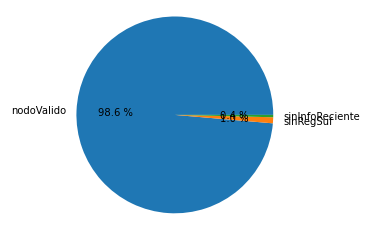

In [188]:
pieChart(Resumen['sel'])

In [189]:
Resumen.head()

,max,count,sel
Nodo,,,
01J,2021-12-01,12,nodoValido
01S,2021-12-01,12,nodoValido
02J,2021-12-01,12,nodoValido
02S,2021-12-01,12,nodoValido
03J,2021-12-01,12,nodoValido


In [190]:
TablaFinal=TablaFinal.merge(Resumen['sel'], left_on='Nodo', right_index=True,how='left')

In [191]:
TablaFinal.head()

,Regional,E_distrito,Nodo,Value,MARCACIONES,CLIENTES,CONTACT,pos,sel
fecha2,,,,,,,,,
2020-01-01,REGION CENTRO,SUBAZAR,10,0.000,4.000,86,4.651,0,nodoValido
2020-01-01,REGION CENTRO,BOLIVIA,11,0.000,3.000,75,4.000,0,nodoValido
2020-01-01,REGION CENTRO,BOLIVIA,12,0.000,16.000,310,5.161,0,nodoValido
2020-01-01,REGION CENTRO,IMPERIAL,13,0.000,15.000,269,5.576,0,nodoValido
2020-01-01,REGION CENTRO,CASTILLA,14,0.000,37.000,523,7.075,0,nodoValido


In [192]:
TablaFinal['sel'].isnull().sum()

94

In [193]:
TablaFinal['sel'].fillna('SinInfo2021',inplace=True)

In [194]:
# guardar registros de nodos no considerados
TablaFinal[TablaFinal['sel']!='nodoValido'].to_csv('NodosNoConsiderados.csv',sep=';')

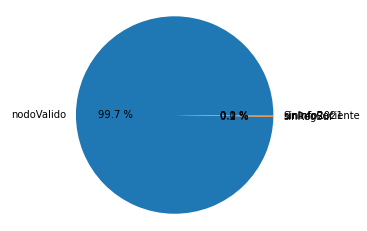

In [195]:
pieChart(TablaFinal['sel'])

In [196]:
TablaFinal=TablaFinal[TablaFinal['sel']=='nodoValido']

In [197]:
len(TablaFinal[TablaFinal['Value']==0])/len(TablaFinal)

0.4234670189793941

In [198]:
TablaTrain=TablaFinal[TablaFinal.index <= fechaTrain]
TablaTest=TablaFinal[TablaFinal.index >= fechaTest]

### Indices Entrenamiento

In [199]:
TablaTrain.index.unique

<bound method Index.unique of DatetimeIndex(['2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
               '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01',
               '2020-01-01', '2020-01-01',
               ...
               '2021-09-01', '2021-09-01', '2021-09-01', '2021-09-01',
               '2021-09-01', '2021-09-01', '2021-09-01', '2021-09-01',
               '2021-09-01', '2021-09-01'],
              dtype='datetime64[ns]', name='fecha2', length=279863, freq=None)>

In [200]:
TablaTrain.index.max()

Timestamp('2021-09-01 00:00:00')

In [201]:
ind = pd.date_range(TablaTrain.index.max(), periods = 4, freq ='MS', name='FECHA')[1:]
ind

DatetimeIndex(['2021-10-01', '2021-11-01', '2021-12-01'], dtype='datetime64[ns]', name='FECHA', freq='MS')

In [202]:
TablaFinal.index.max()

Timestamp('2021-12-01 00:00:00')

In [209]:
numeroTotalNodos=TablaFinal['Nodo'].nunique()
numeroTotalNodos


13695

In [244]:
TablaFinal.sample(6)

,Regional,E_distrito,Nodo,Value,MARCACIONES,CLIENTES,CONTACT,pos,sel
fecha2,,,,,,,,,
2021-04-01,REGION OCCIDENTE,CAQUETA DISTRITO 1,SJF,-0.763,8.000,131,6.107,0,nodoValido
2021-08-01,REGION OCCIDENTE,TOLIMA DISTRITO 1,RL2,-1.158,9.000,259,3.475,0,nodoValido
2021-01-01,REGION CENTRO,CANDELARIA,37C,-0.662,29.000,302,9.603,0,nodoValido
2021-11-01,REGION OCCIDENTE,TOLIMA DISTRITO 2,CTM,-2.564,13.000,195,6.667,0,nodoValido
2020-01-01,REGION ORIENTE,VILLAVICENCIO FUNDADORES,CLG,0.000,5.000,66,7.576,0,nodoValido
2020-05-01,REGION COSTA,BOLIVAR DISTRITO 5,SLG,0.000,13.000,172,7.558,0,nodoValido


In [247]:
NuevaTablaFinal = TablaFinal.to_csv('tablafinal.csv',sep=';', decimal='.')

## Predicciones 

In [210]:
#numeroNodos=300
numeroNodos=numeroTotalNodos

In [211]:
final = pd.DataFrame()
finalErrores = {}
grouped =TablaTrain[['Nodo','Value','MARCACIONES']].groupby('Nodo')
groupedTest =TablaTest[['Nodo','Value','MARCACIONES']].groupby('Nodo')
groupedFinal=TablaFinal[['Nodo','Value','MARCACIONES']].groupby('Nodo')

In [212]:
metodos=['ES','ARIMA','HOLT','ES_ajTend','ARIMAX','ARIMAX2']

In [527]:
#Inicio de validación

In [128]:
#g='ES0'
g='E01BI'

In [129]:
#serie de tiempo
group = grouped.get_group(g)
group

,Nodo,Value,MARCACIONES
fecha2,,,
2020-01-01,E01BI,0.000,0.000
2020-02-01,E01BI,0.000,0.000
2020-08-01,E01BI,0.000,2.000
2020-09-01,E01BI,0.000,1.000
2020-10-01,E01BI,0.000,8.000
2020-11-01,E01BI,-600.000,2.000
2020-12-01,E01BI,-200.000,0.000
2021-01-01,E01BI,-200.000,0.000
2021-02-01,E01BI,-100.000,0.000


In [92]:
group.dtypes

Nodo            object
Value          float64
MARCACIONES    float64
dtype: object

In [130]:
groupTest = groupedTest.get_group(g)
groupTest

,Nodo,Value,MARCACIONES
fecha2,,,
2021-10-01,E01BI,0.000,0.000
2021-11-01,E01BI,0.000,0.000
2021-12-01,E01BI,0.000,0.000


In [94]:
num_start=len(group['Value'])
perPred=len(groupTest['MARCACIONES'])
periodos = 12 if int(num_start/2)>12 else (6 if int(num_start/2)>6 else int(num_start/2))         



In [111]:
periodos=4

In [109]:
group['Value'].astype(float)[10:-1]

fecha2
2020-11-01   -1.471
2020-12-01   -0.942
2021-01-01   -1.198
2021-02-01   -1.346
2021-04-01    0.000
2021-05-01   -0.909
2021-06-01   -1.852
2021-07-01    0.000
2021-08-01   -1.887
Name: Value, dtype: float64

In [118]:
model = ETSModel(group['Value'].astype(float),seasonal_periods=periodos ,error="add",trend="add",seasonal="add", damped_trend=True,)
model = model.fit()                
forecast = pd.DataFrame(model.get_prediction(start=num_start, end=num_start+perPred-1).summary_frame(alpha=0.05)['mean'],index=groupTest.index)


In [114]:
forecast

,mean
fecha2,
2021-10-01,NaN
2021-11-01,NaN
2021-12-01,NaN


In [531]:
group.dtypes

Nodo            object
Value          float64
MARCACIONES    float64
dtype: object

In [465]:
#group['Value']=group['Value'].astype(int)
#group['Value']=group['Value'].astype(float)

In [466]:
#group.dtypes

In [565]:
group['Value'].values

array([ -62.83333333,  -42.33333333, -192.5       ,  -48.75      ,
       -125.6666667 ,  -94.        ,  -95.5       ,  -48.625     ])

In [561]:
#listap=[ -62.83333333,  -42.33333333, -192.5 ,  -48.75 ,-125.6666667 ,  -94.0 ,  -95.5 ,  -48.625  ]

In [700]:
#model=auto_arima(group['Value'].values,trace=False)
#model=auto_arima(listap,trace=False)
#model.fit(group['Value'])  
#model.predict(n_periods = 3)
#forecast=pd.DataFrame(model.predict(n_periods = 3),index=ind)

In [573]:

group.head(1).index.values[0]


numpy.datetime64('2021-02-01T00:00:00.000000000')

In [577]:
group.first_valid_index()

Timestamp('2021-02-01 00:00:00')

In [ ]:
#Fin de validación

In [213]:
i=0
iNodo=0
for g in grouped.groups:
    #print(g)
    if iNodo<numeroNodos:
    #if  iNodo>=6000: 
        if iNodo>numeroNodos:
            continue
        if iNodo%1000==0:
            print(iNodo,g) 
        dicNodo={} 
        dicAuxMetodo={}
        group = grouped.get_group(g) 
        groupTest = groupedTest.get_group(g)
            
        for metodo in metodos:
            #print(g,metodo)
            if metodo== 'ARIMA':
                try: 
                    model=auto_arima(group['Value'].values,trace=False)
                    model.fit(group['Value'])  
                    forecast=pd.DataFrame(model.predict(n_periods = 3),index=ind)#Cambio de la cantidad de meses a predecir "3"
                except:
                    group.at[group.first_valid_index(),'Value']=group.at[group.first_valid_index(),'Value']+0.1
                    model=auto_arima(group['Value'].values,trace=False)
                    model.fit(group['Value'])  
                    forecast=pd.DataFrame(model.predict(n_periods = 3),index=ind)#Cambio de la cantidad de meses a predecir "3"
            elif metodo== 'ES':
                model = SimpleExpSmoothing(group['Value'].values)
                model=model.fit(smoothing_level=.5)
                forecast=pd.DataFrame(model.forecast(3),index=ind)
            elif metodo== 'HOLT':
                model = Holt(group['Value'].values) 
                model = model.fit(optimized=True)
                forecast=pd.DataFrame(model.forecast(3),index=ind)
            elif metodo== 'ES_ajTend':
                model = ExponentialSmoothing(group['Value'].values,trend='add', seasonal=None, damped=True)
                model= model.fit()
                forecast=pd.DataFrame(model.forecast(3),index=ind)
            elif metodo=='ARIMAX':            
                model=sm.tsa.statespace.SARIMAX(group['Value'].values,order=(1, 1, 1),exog=group['MARCACIONES'].values)
                model=model.fit()
                num_start=len(group['Value'])
                perPred=len(groupTest['MARCACIONES'])
                forecast=pd.DataFrame(model.predict(start=num_start,end=num_start+perPred-1,exog=groupTest['MARCACIONES'].values,dynamic=True),index=groupTest.index)

            elif metodo=='ARIMAX2':
                model=auto_arima(group['Value'].values,trace=False,exogenous=group['MARCACIONES'].values.reshape(-1,1))
                perPred=len(groupTest['MARCACIONES'])
                forecast= pd.DataFrame(model.predict(n_periods=perPred,exogenous=groupTest['MARCACIONES'].values.reshape(-1,1)),index=groupTest.index)
                
                
            #elif metodo== 'ETS': 
                #num_start=len(group['Value'])
                #perPred=len(groupTest['MARCACIONES'])
                #periodos = 12 if int(num_start/2)>12 else (6 if int(num_start/2)>6 else int(num_start/2))         
                               
                #model = ETSModel(group['Value'].astype(float),seasonal_periods=periodos ,error="add",trend="add",seasonal="add", damped_trend=True,)
                #model = model.fit()                
                #forecast = pd.DataFrame(model.get_prediction(start=num_start, end=num_start+perPred-1).summary_frame(alpha=0.05)['mean'],index=groupTest.index)
            forecast.columns = ['pred']  
            forecast['Nodo']=g
            forecast['Metodo']=metodo
            if i==0:
                final=forecast
            else:
                final=final.append(forecast)     

            if len(groupTest['Value'])==3:
                #print(1)
                try:
                    RMSE=mean_squared_error(groupTest['Value'].values,forecast['pred'], squared=False)
                    MAPE=mean_absolute_percentage_error(groupTest['Value'].values,forecast['pred'])
                except:
                    RMSE=1000
                    MAPE=1000
            else :
                #print(2)
                tempTest=groupTest.copy()
                tempTest['pred2']=forecast['pred']   
                RMSE=mean_squared_error(tempTest['Value'].values,tempTest['pred2'].values, squared=False)
                MAPE=mean_absolute_percentage_error(tempTest['Value'].values,tempTest['pred2'].values)
            # Errores
            ## Medicion varios errores, seleccionar el que mejor se ajuste
            #RMSE=mean_squared_error(groupTest['Value'],forecast['pred'], squared=False)
            #MAPE=mean_absolute_percentage_error(groupTest['Value'],forecast['pred'])    
            dicNodo[metodo]=RMSE 
            i=i+1
        finalErrores[g]=dicNodo

    iNodo=iNodo+1

0 01J
1000 2IS2D
2000 46B014
3000 61013D
4000 ALE4D
5000 C1213D
6000 DC6
7000 FZ2
8000 JLO
9000 MM0
10000 P2H
11000 RG5
12000 SSB1
13000 VB4


In [215]:

dfFinalErrores=pd.DataFrame.from_dict(finalErrores,orient='index')
dfFinalErrores.to_csv('resultado_Finalerrores_CHURN.csv',sep=';', decimal='.')
final.to_csv('Resultados_entren_test_CHURN.csv',sep=';', decimal='.')


In [ ]:
#len(dfFinalErrores0)

In [216]:
len(dfFinalErrores)

13695

In [217]:
df_dup_rows = dfFinalErrores.index.duplicated(keep = False)
df_dup_rows.sum()

0

In [218]:
len(df_dup_rows)

13695

In [219]:
#len(nodoDuplicados)

In [220]:
dfFinalErrores.head()

,ES,ARIMA,HOLT,ES_ajTend,ARIMAX,ARIMAX2
01J,3.547,1.487,3.365,3.314,3.167,2.117
01S,1.457,1.375,1.172,1.181,1.249,1.419
02J,1.924,1.183,1.393,1.428,1.701,1.735
02S,1.164,1.796,1.562,1.532,1.462,1.850
03J,3.417,2.098,3.690,3.665,3.404,3.806


* Velocidad de procesamiento:  200 Nodos x Minuto

In [221]:
final[final['Metodo']=='ARIMAX2'].head(10)

,pred,Nodo,Metodo
2021-10-01,-1.785,01J,ARIMAX2
2021-11-01,-2.634,01J,ARIMAX2
2021-12-01,-1.824,01J,ARIMAX2
2021-10-01,-0.641,01S,ARIMAX2
2021-11-01,-0.466,01S,ARIMAX2
2021-12-01,-0.466,01S,ARIMAX2
2021-10-01,-1.227,02J,ARIMAX2
2021-11-01,-2.453,02J,ARIMAX2
2021-12-01,-1.227,02J,ARIMAX2
2021-10-01,-2.635,02S,ARIMAX2


In [223]:
final.isnull().sum()

pred      0
Nodo      0
Metodo    0
dtype: int64

* No tiene nullos

## Selección mejor método por Nodo

In [224]:
metodos

['ES', 'ARIMA', 'HOLT', 'ES_ajTend', 'ARIMAX', 'ARIMAX2']

In [225]:
dfFinalErrores=pd.DataFrame.from_dict(finalErrores,orient='index')
dfFinalErrores.head(10)

,ES,ARIMA,HOLT,ES_ajTend,ARIMAX,ARIMAX2
01J,3.547,1.487,3.365,3.314,3.167,2.117
01S,1.457,1.375,1.172,1.181,1.249,1.419
02J,1.924,1.183,1.393,1.428,1.701,1.735
02S,1.164,1.796,1.562,1.532,1.462,1.850
03J,3.417,2.098,3.690,3.665,3.404,3.806
04J,2.789,2.641,2.765,2.634,3.035,2.895
05J,1.930,1.274,2.059,1.609,1.373,1.323
06J,1.274,1.584,1.927,1.625,1.434,1.435
07J,0.588,1.269,1.458,1.340,1.260,1.347
09J,1.048,1.118,1.041,1.358,1.130,1.125


In [226]:
minError=list(dfFinalErrores.min(axis=1).values)
minError[:10]

[1.4867901479483892,
 1.171665477715151,
 1.1826268969047615,
 1.1636343842704322,
 2.0979601605653433,
 2.6340376156161347,
 1.2744522553646385,
 1.2743098943780993,
 0.5878318157322217,
 1.0407251172869219]

In [227]:
modeloSeleccionado=[np.nan]*len(dfFinalErrores)
i=0
for indx,row in dfFinalErrores.iterrows():
    auxRow=list(row.values)
    auxInd=auxRow.index(minError[i])
    modeloSeleccionado[i]=metodos[auxInd]
    #print(auxRow)
    i=i+1

In [228]:
modeloSeleccionado[:10]

['ARIMA',
 'HOLT',
 'ARIMA',
 'ES',
 'ARIMA',
 'ES_ajTend',
 'ARIMA',
 'ES',
 'ES',
 'HOLT']

In [229]:
dfFinalErrores['seleccion']=modeloSeleccionado

In [230]:
dfFinalErrores['errorMin']=minError

In [231]:
dfFinalErrores.head(10)

,ES,ARIMA,HOLT,ES_ajTend,ARIMAX,ARIMAX2,seleccion,errorMin
01J,3.547,1.487,3.365,3.314,3.167,2.117,ARIMA,1.487
01S,1.457,1.375,1.172,1.181,1.249,1.419,HOLT,1.172
02J,1.924,1.183,1.393,1.428,1.701,1.735,ARIMA,1.183
02S,1.164,1.796,1.562,1.532,1.462,1.850,ES,1.164
03J,3.417,2.098,3.690,3.665,3.404,3.806,ARIMA,2.098
04J,2.789,2.641,2.765,2.634,3.035,2.895,ES_ajTend,2.634
05J,1.930,1.274,2.059,1.609,1.373,1.323,ARIMA,1.274
06J,1.274,1.584,1.927,1.625,1.434,1.435,ES,1.274
07J,0.588,1.269,1.458,1.340,1.260,1.347,ES,0.588
09J,1.048,1.118,1.041,1.358,1.130,1.125,HOLT,1.041


In [232]:
dfFinalErrores['seleccion'].value_counts()

ARIMA        3749
ARIMAX2      3345
ES           2595
ARIMAX       2046
ES_ajTend    1369
HOLT          591
Name: seleccion, dtype: int64

## Predicción Final

In [233]:
ind_P = pd.date_range(fechaMaxima, periods = 4, freq ='MS', name='FECHA')[1:]#cantidad de meses a predecir 
ind_P

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01'], dtype='datetime64[ns]', name='FECHA', freq='MS')

In [234]:
finalPrediccionesFuturas = pd.DataFrame()
groupedPred =TablaFinal[['Nodo','Value','MARCACIONES']].groupby('Nodo')

In [235]:
dfFinalErrores.loc['01J']

ES           3.547
ARIMA        1.487
HOLT         3.365
ES_ajTend    3.314
ARIMAX       3.167
ARIMAX2      2.117
seleccion    ARIMA
errorMin     1.487
Name: 01J, dtype: object

In [236]:
i=0
for g in groupedPred.groups:
    if i>=numeroNodos:
        continue
    if i%1000==0:
        print(i,g)    
    group = groupedPred.get_group(g)        
    mejorMetodo=dfFinalErrores.loc[g,'seleccion']
    #print(mejorMetodo)
    #metodo=dicMetodos[g][mejorMetodo]
    #forecast=model.predict(group['Value'])
    if mejorMetodo== 'ARIMA':
        model=auto_arima(group['Value'].values,trace=False)
        model.fit(group['Value'])  
        forecast=pd.DataFrame(model.predict(n_periods = 3),index=ind_P)
    elif mejorMetodo== 'ES':
        model = SimpleExpSmoothing(group['Value'].values)
        model=model.fit(smoothing_level=.5)
        forecast=pd.DataFrame(model.forecast(3),index=ind_P)
    elif mejorMetodo== 'HOLT':
        model = Holt(group['Value'].values) 
        model = model.fit(optimized=True)
        forecast=pd.DataFrame(model.forecast(3),index=ind_P)
    elif mejorMetodo== 'ES_ajTend':
        model = ExponentialSmoothing(group['Value'].values,trend='add', seasonal=None, damped=True)
        model= model.fit()
        forecast=pd.DataFrame(model.forecast(3),index=ind_P)
    elif mejorMetodo=='ARIMAX':        
        model=sm.tsa.statespace.SARIMAX(group['Value'].values,order=(1, 1, 1),exog=group['MARCACIONES'].values)
        model=model.fit()            
        num_start=len(group['Value'])
        forecast=pd.DataFrame(model.predict(start=num_start,end=num_start+2,exog=group['MARCACIONES'].values[-3:],dynamic=True),index=ind_P)
        #forecast=pd.DataFrame(results.predict(n_periods = 3,dynamic=True),index=ind_P)
    elif metodo=='ARIMAX2':
        model=auto_arima(group['Value'].values,trace=False,exogenous=group['MARCACIONES'].values.reshape(-1,1))
        forecast= pd.DataFrame(model.predict(n_periods=3,exogenous=group['MARCACIONES'].values[-3:].reshape(-1,1)),index=ind_P)
            
    #elif metodo== 'ETS': 
        #num_start=len(group['Value'])
        #perPred= 3
        #periodos = 12 if int(num_start/2)>12 else (6 if int(num_start/2)>6 else int(num_start/2))         

        #model = ETSModel(group['Value'].astype(float),seasonal_periods=periodos ,error="add",trend="add",seasonal="add", damped_trend=True,)
        #model = model.fit()                
        #forecast = pd.DataFrame(model.get_prediction(start=num_start, end=num_start+perPred-1).summary_frame(alpha=0.05)['mean'],index=ind_P)       

    
    forecast.columns = ['pred']
    forecast['Nodo']=g
    forecast['Metodo']=mejorMetodo

    if i==0:
        finalPrediccionesFuturas=forecast
    else:
        finalPrediccionesFuturas=finalPrediccionesFuturas.append(forecast) 
    i=i+1
        

0 01J
1000 2IS2D
2000 46B014
3000 61013D
4000 ALE4D
5000 C1213D
6000 DC6
7000 FZ2
8000 JLO
9000 MM0
10000 P2H
11000 RG5
12000 SSB1
13000 VB4


In [237]:
#Reemplazar positivos por cero
finalPrediccionesFuturas['pred']=np.where(finalPrediccionesFuturas['pred']>0,0,finalPrediccionesFuturas['pred'])

In [238]:
finalPrediccionesFuturas.sample(10)

,pred,Nodo,Metodo
FECHA,,,
2022-01-01,-1.042,CCQ,ARIMAX2
2022-02-01,-1.341,39I2D,HOLT
2022-02-01,0.000,EP3,ARIMA
2022-01-01,-0.019,3LA,ES
2022-03-01,-0.586,SMX,ARIMAX2
2022-02-01,-1.332,J1R,ES_ajTend
2022-01-01,-2.053,IMO,ARIMAX
2022-02-01,-0.130,FOE,ES
2022-03-01,-0.537,BE2,ARIMA


## MERGE

In [239]:
resultadoFinal=finalPrediccionesFuturas.reset_index().merge(maestroNodo,left_on='Nodo',right_on='Nodo',how='left')
resultadoFinal.head(5)

,FECHA,pred,Nodo,Metodo,E_distrito,Regional
0,2022-01-01,-0.624,01J,ARIMA,CORDOBA SUCRE DISTRITO 3,REGION COSTA
1,2022-02-01,-1.109,01J,ARIMA,CORDOBA SUCRE DISTRITO 3,REGION COSTA
2,2022-03-01,-1.109,01J,ARIMA,CORDOBA SUCRE DISTRITO 3,REGION COSTA
3,2022-01-01,-1.519,01S,HOLT,GAITANA,REGION CENTRO
4,2022-02-01,-1.578,01S,HOLT,GAITANA,REGION CENTRO


In [240]:
resultadoFinal.to_csv('resultadoPrediciones_CHURN.csv',sep=';',decimal='.')

In [241]:
final.head()

,pred,Nodo,Metodo
2021-10-01,-3.547,01J,ES
2021-11-01,-3.547,01J,ES
2021-12-01,-3.547,01J,ES
2021-10-01,-1.787,01J,ARIMA
2021-11-01,-1.311,01J,ARIMA


In [242]:
len(final)

246468

In [134]:
final.to_csv('final.csv',sep=';',decimal='.')

# PREDICCIÓN CONTACT POR NODO

In [ ]:
TablaFinalC=TablaMarClient.merge(TablaChurn,left_on=['NODO','FECHA'],right_on=['Nodo','fecha2'], how='left')

In [ ]:
TablaFinalC.head()

In [ ]:
TablaFinalC.isnull().sum()

In [101]:
TablaFinalC[TablaFinalC['Nodo'].isnull()].head(10)

,REGIONAL,Distrito,NODO,MARCACIONES,CLIENTES,CONTACT,MES,ANIO,DIA,FECHA1,FECHA,Regional,E_distrito,Nodo,Fecha,Value,fecha2


In [102]:
Reg_Churn_NoenContact=TablaFinalC[TablaFinalC['Nodo'].isnull()]
Reg_Churn_NoenContact.to_csv('Reg_Contact_NoenChurn.csv',sep=';',decimal='.')

In [103]:
len(TablaFinalC)

321874

In [104]:
TablaFinalC.drop(columns=['Fecha','fecha2','ANIO','MES','DIA','FECHA1','Nodo','E_distrito','Regional'], inplace=True)

In [105]:
TablaFinalC.sample(10)

,REGIONAL,Distrito,NODO,MARCACIONES,CLIENTES,CONTACT,FECHA,Value
249798,REGION NOROCCIDENTE,MEDELLIN SURORIENTAL,PT6,6.000,68,8.824,2021-07-01,-1.471
233824,REGION COSTA,BARRANQUILLA 2 DISTRITO 2,L4N,4.000,76,5.263,2021-06-01,0.000
5899,REGION ORIENTE,DISTRITO FLORIDA 2,DST,4.000,92,4.348,2020-01-01,0.000
70535,REGION NOROCCIDENTE,MEDELLIN SURORIENTAL,CD3,3.000,33,9.091,2020-06-01,-3.030
256337,REGION CENTRO,PONTEVEDRA,8A5014,6.000,88,6.818,2021-08-01,-1.136
49220,REGION NOROCCIDENTE,MEDELLIN SURORIENTAL,PT2,1.000,14,7.143,2020-04-01,0.000
89502,REGION COSTA,BARRANQUILLA 2 DISTRITO 2,S5V,13.000,76,17.105,2020-07-01,0.000
117243,REGION ORIENTE,VILLAVICENCIO CATAMA,V26,24.000,263,9.125,2020-09-01,-2.281
262869,REGION NOROCCIDENTE,MEDELLIN SUROCCIDENTAL,ON5,8.000,302,2.649,2021-08-01,-1.656
106087,REGION CENTRO,GALERIAS,31A024,16.000,157,10.191,2020-09-01,0.000


In [106]:
# colocar la fecha como index
TablaFinalC.set_index('FECHA',inplace=True)

In [107]:
TablaFinalC.index=pd.to_datetime(TablaFinalC.index)

In [108]:
TablaFinalC['Value'].fillna(0,inplace=True)

In [109]:
TablaFinalC.sample(20)

,REGIONAL,Distrito,NODO,MARCACIONES,CLIENTES,CONTACT,Value
FECHA,,,,,,,
2021-01-01,REGION CENTRO,SAN FERNANDO,48B4D,1.000,43,2.326,-2.326
2021-05-01,REGION CENTRO,PONTEVEDRA,MEV,4.000,138,2.899,-1.449
2020-06-01,REGION OCCIDENTE,TOLIMA DISTRITO 3,DY1,26.000,309,8.414,-1.294
2020-09-01,REGION OCCIDENTE,TOLIMA DISTRITO 3,4MV,7.000,110,6.364,-2.727
2021-02-01,REGION NOROCCIDENTE,BELLO METROPOLITANO,4LC,5.000,67,7.463,0.000
2021-04-01,REGION OCCIDENTE,CALI SUR DISTRITO 7,RIO,9.000,70,12.857,-2.857
2021-08-01,REGION CENTRO,PUENTE ARANDA,5901,19.000,349,5.444,-0.860
2021-02-01,REGION ORIENTE,DISTRITO BGA 2,6SU,7.000,74,9.459,-1.351
2020-06-01,REGION CENTRO,CEDRITOS,5AI014,7.000,71,9.859,-1.408


### Identificación y corrección de negativos

In [110]:
TablaFinalC['neg']=np.where(TablaFinalC['CONTACT']<0,1,0)

In [111]:
TablaFinalC[TablaFinalC['neg']==1].count()

REGIONAL       0
Distrito       0
NODO           0
MARCACIONES    0
CLIENTES       0
CONTACT        0
Value          0
neg            0
dtype: int64

## Construcción de Maestro Nodos

In [112]:
maestroNodoC=TablaFinalC[['NODO','Distrito','REGIONAL']]

In [113]:
# sorting by first name
maestroNodoC.sort_index(ascending=True, inplace = True)
 
# dropping ALL duplicate values
maestroNodoC.drop_duplicates(subset =["NODO"], keep = 'last', inplace = True)

In [114]:
maestroNodoC.head(3)

,NODO,Distrito,REGIONAL
FECHA,,,
2020-01-01,PDV,PEREIRA5,REGION NOROCCIDENTE
2020-02-01,AS34A,NaN,NaN
2020-03-01,IAB,NaN,NaN


In [115]:
maestroNodoC[maestroNodoC['NODO']=='LCR14D']

,NODO,Distrito,REGIONAL
FECHA,,,
2021-12-01,LCR14D,EL ENSUE?O,REGION CENTRO


##  Separación Entrenamiento y testing

In [116]:
fechaMaxima=max(TablaFinalC.index)
fechaMaxima

Timestamp('2021-12-01 00:00:00')

In [117]:
TablaFinalC.index.unique()

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', name='FECHA', freq=None)

In [118]:
fechaTrain=TablaFinalC.index.unique()[-4]
fechaTest=TablaFinalC.index.unique()[-3]

In [119]:
print (fechaTrain,fechaTest)

2021-09-01 00:00:00 2021-10-01 00:00:00


## Seleccion de Nodos
* Nodos con información en los últimos 3 meses
* Nodos con más de 7 registros (por entrenamiento y pruebas)

In [120]:
len(TablaFinalC[TablaFinalC.index>='2021-01-01'])

163881

In [121]:
# Nodos con información en los últimos 3 meses
ResumenC=TablaFinalC[TablaFinalC.index>='2021-01-01'].reset_index()[['FECHA','NODO']].groupby('NODO').agg(['max','count'])

In [122]:
ResumenC.head(2)

FECHA      
            max count
NODO                 
01J  2021-12-01    12
01S  2021-12-01    12

In [123]:
ResumenC.columns = ResumenC.columns.droplevel(0)

In [124]:
ResumenC['max'].value_counts()

2021-12-01    13812
2021-11-01       20
2021-01-01       19
2021-09-01       12
2021-08-01        5
2021-04-01        5
2021-07-01        3
2021-06-01        3
2021-02-01        3
2021-05-01        2
2021-10-01        1
Name: max, dtype: int64

In [125]:
ResumenC['sel']=np.where(ResumenC['max']<=fechaTest,'sinInfoReciente','nodoValido')

In [126]:
ResumenC['sel'].value_counts()

nodoValido         13832
sinInfoReciente       53
Name: sel, dtype: int64

In [127]:
# Nodos con más de 7 registros (por entrenamiento y pruebas)

In [128]:
ResumenC['count'].value_counts()

12    13402
8       145
1        60
2        49
9        48
7        48
10       35
11       29
5        25
4        18
3        17
6         9
Name: count, dtype: int64

In [129]:
ResumenC['sel']=np.where(ResumenC['sel']=='nodoValido', np.where(ResumenC['count']<7,'sinRegSuf','nodoValido'),ResumenC['sel'])

In [130]:
ResumenC['sel'].value_counts()

nodoValido         13695
sinRegSuf            137
sinInfoReciente       53
Name: sel, dtype: int64

In [131]:
ResumenC.head()

,max,count,sel
NODO,,,
01J,2021-12-01,12,nodoValido
01S,2021-12-01,12,nodoValido
02J,2021-12-01,12,nodoValido
02S,2021-12-01,12,nodoValido
03J,2021-12-01,12,nodoValido


In [132]:
TablaFinalC=TablaFinalC.merge(ResumenC['sel'], left_on='NODO', right_index=True,how='left')

In [133]:
TablaFinalC.head()

,REGIONAL,Distrito,NODO,MARCACIONES,CLIENTES,CONTACT,Value,neg,sel
FECHA,,,,,,,,,
2020-01-01,REGION CENTRO,SUBAZAR,10,4.000,86,4.651,0.000,0,nodoValido
2020-01-01,REGION CENTRO,BOLIVIA,11,3.000,75,4.000,0.000,0,nodoValido
2020-01-01,REGION CENTRO,BOLIVIA,12,16.000,310,5.161,0.000,0,nodoValido
2020-01-01,REGION CENTRO,IMPERIAL,13,15.000,269,5.576,0.000,0,nodoValido
2020-01-01,REGION CENTRO,CASTILLA,14,37.000,523,7.075,0.000,0,nodoValido


In [134]:
TablaFinalC['sel'].isnull().sum()

94

In [135]:
TablaFinalC['sel'].fillna('SinInfo2021',inplace=True)

In [136]:
# guardar registros de nodos no considerados
TablaFinalC[TablaFinalC['sel']!='nodoValido'].to_csv('NodosNoConsiderados.csv',sep=';',decimal='.')

In [137]:
TablaFinalC=TablaFinalC[TablaFinalC['sel']=='nodoValido']

In [138]:
len(TablaFinalC[TablaFinalC['CONTACT']==0])/len(TablaFinalC)

0.03827350145048562

In [139]:
TablaTrain=TablaFinalC[TablaFinalC.index <= fechaTrain]
TablaTest=TablaFinalC[TablaFinalC.index >= fechaTest]

### Indices Entrenamiento

In [140]:
ind = pd.date_range(TablaTrain.index.max(), periods = 4, freq ='MS', name='FECHA')[1:]
ind

DatetimeIndex(['2021-10-01', '2021-11-01', '2021-12-01'], dtype='datetime64[ns]', name='FECHA', freq='MS')

In [141]:
TablaFinalC.index.max()

Timestamp('2021-12-01 00:00:00')

In [142]:
numeroTotalNodos=TablaFinalC['NODO'].nunique()
numeroTotalNodos

13695

## Predicciones

In [143]:
#numeroNodos=500
numeroNodos=numeroTotalNodos

In [144]:
final = pd.DataFrame()
finalErrores = {}
grouped =TablaTrain[['NODO','CONTACT','Value']].groupby('NODO')
groupedTest =TablaTest[['NODO','CONTACT','Value']].groupby('NODO')
groupedFinal=TablaFinalC[['NODO','CONTACT','Value']].groupby('NODO')

In [145]:
metodos=['ES','ARIMA','HOLT','ES_ajTend','ARIMAX','ARIMAX2']

In [ ]:
i=0
iNodo=0
for g in grouped.groups:
    #print(g)
    if iNodo<numeroNodos:
    #if  iNodo>=11000: 
        if iNodo>numeroNodos:
            continue
        if iNodo%1000==0:
            print(iNodo,g)    
        dicNodo={} 
        dicAuxMetodo={}
        group = grouped.get_group(g) 
        groupTest = groupedTest.get_group(g) 
        for metodo in metodos:
            #print(g,metodo)            
            if metodo== 'ARIMA':
                try: 
                    model=auto_arima(group['CONTACT'].values,trace=False)
                    model.fit(group['CONTACT'])  
                    forecast=pd.DataFrame(model.predict(n_periods = 3),index=ind)#Cambio de la cantidad de meses a predecir "3"
                except:
                    group.at[group.first_valid_index(),'CONTACT']=group.at[group.first_valid_index(),'CONTACT']+0.1
                    model=auto_arima(group['CONTACT'].values,trace=False)
                    model.fit(group['CONTACT'])  
                    forecast=pd.DataFrame(model.predict(n_periods = 3),index=ind)#Cambio de la cantidad de meses a predecir "3"
            elif metodo== 'ES':
                model = SimpleExpSmoothing(group['CONTACT'].values)
                model=model.fit(smoothing_level=.5)
                forecast=pd.DataFrame(model.forecast(3),index=ind)
            elif metodo== 'HOLT':
                model = Holt(group['CONTACT'].values) 
                model = model.fit(optimized=True)
                forecast=pd.DataFrame(model.forecast(3),index=ind)
            elif metodo== 'ES_ajTend':
                model = ExponentialSmoothing(group['CONTACT'].values,trend='add', seasonal=None, damped=True)
                model= model.fit()
                forecast=pd.DataFrame(model.forecast(3),index=ind)
            elif metodo=='ARIMAX':            
                model=sm.tsa.statespace.SARIMAX(group['CONTACT'].values,order=(1, 1, 1),exog=group['Value'].values,initialization='approximate_diffuse')
                model=model.fit()
                num_start=len(group['CONTACT'])
                perPred=len(groupTest['Value'])
                forecast=pd.DataFrame(model.predict(start=num_start,end=num_start+perPred-1,exog=groupTest['Value'].values,dynamic=True),index=groupTest.index)

            elif metodo=='ARIMAX2':
                model=auto_arima(group['CONTACT'].values,trace=False,exogenous=group['Value'].values.reshape(-1,1))
                perPred=len(groupTest['Value'])
                forecast= pd.DataFrame(model.predict(n_periods=perPred,exogenous=groupTest['Value'].values.reshape(-1,1)),index=groupTest.index)

            elif metodo== 'ETS': 
                num_start=len(group['CONTACT'])
                perPred=len(groupTest['Value'])
                periodos = 12 if int(num_start/2)>12 else (6 if int(num_start/2)>6 else int(num_start/2))         

                model = ETSModel(group['CONTACT'].astype(float),seasonal_periods=periodos ,error="add",trend="add",seasonal="add", damped_trend=True,)
                model = model.fit()                
                forecast = pd.DataFrame(model.get_prediction(start=num_start, end=num_start+perPred-1).summary_frame(alpha=0.05)['mean'],index=groupTest.index) 
            forecast.columns = ['pred']  
            forecast['NODO']=g
            forecast['Metodo']=metodo
            if i==0:
                final=forecast
            else:
                final=final.append(forecast)     

            if len(groupTest['CONTACT'])==3:
                #print(1)
                RMSE=mean_squared_error(groupTest['CONTACT'],forecast['pred'], squared=False)
                MAPE=mean_absolute_percentage_error(groupTest['CONTACT'],forecast['pred'])
            else :
                #print(2)
                tempTest=groupTest.copy()
                tempTest['pred2']=forecast['pred']   
                RMSE=mean_squared_error(tempTest['CONTACT'].values,tempTest['pred2'].values, squared=False)
                MAPE=mean_absolute_percentage_error(tempTest['CONTACT'].values,tempTest['pred2'].values)
            # Errores
        ## Medicion varios errores, seleccionar el que mejor se ajuste
        #RMSE=mean_squared_error(groupTest['Value'],forecast['pred'], squared=False)
        #MAPE=mean_absolute_percentage_error(groupTest['Value'],forecast['pred'])    
            dicNodo[metodo]=RMSE 
            i=i+1
        finalErrores[g]=dicNodo

    iNodo=iNodo+1

0 01J
1000 2IS2D
2000 46B014


In [793]:
dfFinalErrores=pd.DataFrame.from_dict(finalErrores,orient='index')
dfFinalErrores.to_csv('resultado_Finalerrores_CONTACT.csv',sep=';',decimal='.')
final.to_csv('Resultados_entren_test_CONTACT.csv',sep=';',decimal='.')

In [794]:
len(dfFinalErrores)

14772

In [795]:
dfFinalErrores.head()

,ES,ARIMA,HOLT,ES_ajTend,ARIMAX,ARIMAX2
01S,4.504,4.685,4.034,4.064,8.136,8.201
02J,3.592,6.976,13.078,7.630,3.529,6.976
02S,11.889,9.361,21.968,14.844,14.938,8.339
03J,5.953,5.210,7.760,7.627,7.349,7.262
04J,20.992,20.202,35.925,25.852,29.506,32.558


In [796]:
final[final['Metodo']=='ARIMAX2'].head(10)

,pred,NODO,Metodo
FECHA,,,
2021-06-01,8.559,01S,ARIMAX2
2021-07-01,10.316,01S,ARIMAX2
2021-08-01,17.024,01S,ARIMAX2
2021-06-01,15.187,02J,ARIMAX2
2021-07-01,15.187,02J,ARIMAX2
2021-08-01,15.187,02J,ARIMAX2
2021-06-01,16.536,02S,ARIMAX2
2021-07-01,17.021,02S,ARIMAX2
2021-08-01,11.680,02S,ARIMAX2


In [797]:
final.isnull().sum()

pred      0
NODO      0
Metodo    0
dtype: int64

## Selección mejor método por Nodo

In [798]:
metodos

['ES', 'ARIMA', 'HOLT', 'ES_ajTend', 'ARIMAX', 'ARIMAX2']

In [799]:
dfFinalErrores=pd.DataFrame.from_dict(finalErrores,orient='index')
dfFinalErrores.head(10)

,ES,ARIMA,HOLT,ES_ajTend,ARIMAX,ARIMAX2
01S,4.504,4.685,4.034,4.064,8.136,8.201
02J,3.592,6.976,13.078,7.630,3.529,6.976
02S,11.889,9.361,21.968,14.844,14.938,8.339
03J,5.953,5.210,7.760,7.627,7.349,7.262
04J,20.992,20.202,35.925,25.852,29.506,32.558
05J,3.795,3.816,3.933,3.931,5.734,7.104
06J,24.994,23.439,24.582,27.604,26.178,25.182
07J,3.889,3.294,7.028,5.724,3.858,3.090
09J,27.282,25.944,26.086,26.115,32.487,29.605
0A6,7.401,11.655,2.155,2.487,7.424,6.682


In [800]:
minError=list(dfFinalErrores.min(axis=1).values)
minError[:10]

[4.034109519040695,
 3.5290828687897764,
 8.339345504768557,
 5.209952293566196,
 20.201586784032084,
 3.795459230633806,
 23.438783945934514,
 3.089578085835893,
 25.94418850599432,
 2.1549771313867807]

In [801]:
modeloSeleccionado=[np.nan]*len(dfFinalErrores)
i=0
for indx,row in dfFinalErrores.iterrows():
    auxRow=list(row.values)
    auxInd=auxRow.index(minError[i])
    modeloSeleccionado[i]=metodos[auxInd]
    #print(auxRow)
    i=i+1

In [802]:
modeloSeleccionado[:10]

['HOLT',
 'ARIMAX',
 'ARIMAX2',
 'ARIMA',
 'ARIMA',
 'ES',
 'ARIMA',
 'ARIMAX2',
 'ARIMA',
 'HOLT']

In [803]:
dfFinalErrores['seleccion']=modeloSeleccionado

In [804]:
dfFinalErrores['errorMin']=minError

In [805]:
dfFinalErrores.head(10)

,ES,ARIMA,HOLT,ES_ajTend,ARIMAX,ARIMAX2,seleccion,errorMin
01S,4.504,4.685,4.034,4.064,8.136,8.201,HOLT,4.034
02J,3.592,6.976,13.078,7.630,3.529,6.976,ARIMAX,3.529
02S,11.889,9.361,21.968,14.844,14.938,8.339,ARIMAX2,8.339
03J,5.953,5.210,7.760,7.627,7.349,7.262,ARIMA,5.210
04J,20.992,20.202,35.925,25.852,29.506,32.558,ARIMA,20.202
05J,3.795,3.816,3.933,3.931,5.734,7.104,ES,3.795
06J,24.994,23.439,24.582,27.604,26.178,25.182,ARIMA,23.439
07J,3.889,3.294,7.028,5.724,3.858,3.090,ARIMAX2,3.090
09J,27.282,25.944,26.086,26.115,32.487,29.605,ARIMA,25.944
0A6,7.401,11.655,2.155,2.487,7.424,6.682,HOLT,2.155


In [806]:
dfFinalErrores['seleccion'].value_counts()

ES           3994
HOLT         2791
ARIMA        2426
ES_ajTend    2225
ARIMAX2      1689
ARIMAX       1647
Name: seleccion, dtype: int64

## Predicción Final Contact

In [807]:
ind_P = pd.date_range(fechaMaxima, periods = 5, freq ='MS', name='FECHA')[1:]
ind_P

DatetimeIndex(['2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'], dtype='datetime64[ns]', name='FECHA', freq='MS')

In [808]:
finalPrediccionesFuturasC = pd.DataFrame()
groupedPred =TablaFinalC[['NODO','CONTACT','Value']].groupby('NODO')

In [135]:
i=0
for g in groupedPred.groups:
    if i>=numeroNodos:
        break
        #continue
    if i%1000==0:
        print(i,g)    
    group = groupedPred.get_group(g)        
    mejorMetodo=dfFinalErrores.loc[g,'seleccion']
    #print(mejorMetodo)
    #metodo=dicMetodos[g][mejorMetodo]
    #forecast=model.predict(group['Value'])
    if mejorMetodo== 'ARIMA':
        model=auto_arima(group['CONTACT'].values,trace=False)
        model.fit(group['CONTACT'])  
        forecast=pd.DataFrame(model.predict(n_periods = 4),index=ind_P)
    elif mejorMetodo== 'ES':
        model = SimpleExpSmoothing(group['CONTACT'].values)
        model=model.fit(smoothing_level=.5)
        forecast=pd.DataFrame(model.forecast(4),index=ind_P)
    elif mejorMetodo== 'HOLT':
        model = Holt(group['CONTACT'].values) 
        model = model.fit(optimized=True)
        forecast=pd.DataFrame(model.forecast(4),index=ind_P)
    elif mejorMetodo== 'ES_ajTend':
        model = ExponentialSmoothing(group['CONTACT'].values,trend='add', seasonal=None, damped=True)
        model= model.fit()
        forecast=pd.DataFrame(model.forecast(4),index=ind_P)
    elif mejorMetodo=='ARIMAX':        
        model=sm.tsa.statespace.SARIMAX(group['CONTACT'].values,order=(1, 1, 1),exog=group['Value'].values,initialization='approximate_diffuse')
        model=model.fit()            
        num_start=len(group['CONTACT'])
        forecast=pd.DataFrame(model.predict(start=num_start,end=num_start+3,exog=group['Value'].values[-4:],dynamic=True),index=ind_P)
        #forecast=pd.DataFrame(results.predict(n_periods = 3,dynamic=True),index=ind_P)
    elif metodo=='ARIMAX2':
            model=auto_arima(group['CONTACT'].values,trace=False,exogenous=group['Value'].values.reshape(-1,1))
            forecast= pd.DataFrame(model.predict(n_periods=4,exogenous=group['Value'].values[-4:].reshape(-1,1)),index=ind_P)
    
    forecast.columns = ['pred']
    forecast['NODO']=g
    forecast['Metodo']=mejorMetodo

    if i==0:
        finalPrediccionesFuturasC=forecast
    else:
        finalPrediccionesFuturasC=finalPrediccionesFuturasC.append(forecast) 
    i=i+1
        

0 01J


KeyError: 'CONTACT'

In [810]:
finalPrediccionesFuturasC.sample(10)

,pred,NODO,Metodo
FECHA,,,
2021-11-01,4.791,P2B,HOLT
2021-09-01,12.114,MRT,ES
2021-10-01,31.039,DN12D,ARIMA
2021-11-01,5.279,TB23,HOLT
2021-11-01,12.218,SC23D,ES_ajTend
2021-11-01,14.934,IGC,ARIMAX
2021-12-01,18.805,B4O,ES_ajTend
2021-10-01,13.749,R5C,ES
2021-12-01,19.769,3IE,ARIMAX


In [811]:
maestroNodoC.head()

,NODO,Distrito,REGIONAL
FECHA,,,
2020-09-01,CFLU1F,CAQUETA DISTRITO 1,REGION OCCIDENTE
2020-09-01,CSMU1C,SOGAMOSO NORTE,REGION ORIENTE
2020-09-01,CSMU1B,SOGAMOSO NORTE,REGION ORIENTE
2020-09-01,42V,CALI SUR DISTRITO 1,REGION OCCIDENTE
2020-09-01,V6Q,CALI NORTE DISTRITO 6,REGION OCCIDENTE


In [812]:
resultadoFinalC=finalPrediccionesFuturasC.reset_index().merge(maestroNodoC,left_on='NODO',right_on='NODO',how='left')
resultadoFinalC.head(5)

,FECHA,pred,NODO,Metodo,Distrito,REGIONAL
0,2021-09-01,12.996,01S,HOLT,GAITANA,REGION CENTRO
1,2021-10-01,12.425,01S,HOLT,GAITANA,REGION CENTRO
2,2021-11-01,11.853,01S,HOLT,GAITANA,REGION CENTRO
3,2021-12-01,11.281,01S,HOLT,GAITANA,REGION CENTRO
4,2021-09-01,9.022,02J,ARIMAX,NaN,NaN


In [813]:
resultadoFinalC.to_csv('Prediciones_Contact_Rate.csv',sep=';',decimal='.')

## UNION DE RESULTADOS

### Tabla final de Churn



In [814]:
resultadoFinalC= pd.read_csv(f'Prediciones_Contact_Rate.csv',sep=';', decimal=',').drop(columns=['Unnamed: 0'])
resultadoFinal=pd.read_csv(f'resultadoPrediciones_CHURN.csv',sep=';', decimal=',').drop(columns=['Unnamed: 0'])

In [815]:
resultadoFinal.head()

,FECHA,pred,Nodo,Metodo,E_distrito,Regional
0,2021-11-01,-0.770,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA
1,2021-12-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA
2,2022-01-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA
3,2021-11-01,-6.267,01S,ARIMAX2,GAITANA,REGION CENTRO
4,2021-12-01,-0.216,01S,ARIMAX2,GAITANA,REGION CENTRO


In [816]:
#Si es necesario 
#resultadoFinal.drop(columns)
#resultadoFinal.drop(columns=['p10_x','p60_x','p10_y','p60_y'], inplace=True)

In [817]:
resultadoFinal.head()

,FECHA,pred,Nodo,Metodo,E_distrito,Regional
0,2021-11-01,-0.770,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA
1,2021-12-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA
2,2022-01-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA
3,2021-11-01,-6.267,01S,ARIMAX2,GAITANA,REGION CENTRO
4,2021-12-01,-0.216,01S,ARIMAX2,GAITANA,REGION CENTRO


In [818]:
#selcol=['pred']
#resultadoFinal['suma']=resultadoFinal[selcol].sum(axis=1)
#resultadoFinal.suma

In [819]:
Percentiles_Regional=resultadoFinal[['pred','Regional']].groupby('Regional').quantile(0.10)
Percentiles_Regional.columns=['p10']

In [820]:
Percentiles_Regional

,p10
Regional,
REGION CENTRO,-18.409
REGION COSTA,-12.242
REGION NOROCCIDENTE,-14.364
REGION OCCIDENTE,-17.992
REGION ORIENTE,-13.793


In [821]:
Percentiles_Regional1=resultadoFinal[['pred','Regional']].groupby('Regional').quantile(0.60)
Percentiles_Regional1.columns=['p60']

In [822]:
Percentiles_Regional1

,p60
Regional,
REGION CENTRO,-4.637
REGION COSTA,-1.753
REGION NOROCCIDENTE,-2.167
REGION OCCIDENTE,-4.135
REGION ORIENTE,-1.966


In [823]:
resultadoFinal=resultadoFinal.merge(Percentiles_Regional, left_on='Regional', right_index=True, how='left').merge(Percentiles_Regional1, left_on='Regional', right_index=True, how='left')
resultadoFinal.head()

,FECHA,pred,Nodo,Metodo,E_distrito,Regional,p10,p60
0,2021-11-01,-0.770,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753
1,2021-12-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753
2,2022-01-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753
3,2021-11-01,-6.267,01S,ARIMAX2,GAITANA,REGION CENTRO,-18.409,-4.637
4,2021-12-01,-0.216,01S,ARIMAX2,GAITANA,REGION CENTRO,-18.409,-4.637


In [824]:
resultadoFinal.head()

,FECHA,pred,Nodo,Metodo,E_distrito,Regional,p10,p60
0,2021-11-01,-0.770,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753
1,2021-12-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753
2,2022-01-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753
3,2021-11-01,-6.267,01S,ARIMAX2,GAITANA,REGION CENTRO,-18.409,-4.637
4,2021-12-01,-0.216,01S,ARIMAX2,GAITANA,REGION CENTRO,-18.409,-4.637


In [825]:
resultadoFinal['tipoChurn']=np.where(resultadoFinal['pred']<resultadoFinal['p10'],'MALO_CHURN',np.where(resultadoFinal['pred']<resultadoFinal['p60'],'REGULAR_CHURN','BUENO_CHURN'))
resultadoFinal.head()

,FECHA,pred,Nodo,Metodo,E_distrito,Regional,p10,p60,tipoChurn
0,2021-11-01,-0.770,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753,BUENO_CHURN
1,2021-12-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753,BUENO_CHURN
2,2022-01-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753,BUENO_CHURN
3,2021-11-01,-6.267,01S,ARIMAX2,GAITANA,REGION CENTRO,-18.409,-4.637,REGULAR_CHURN
4,2021-12-01,-0.216,01S,ARIMAX2,GAITANA,REGION CENTRO,-18.409,-4.637,BUENO_CHURN


In [826]:
resultadoFinal[resultadoFinal['tipoChurn']=='MALO_CHURN'].head()


,FECHA,pred,Nodo,Metodo,E_distrito,Regional,p10,p60,tipoChurn
47,2022-01-01,-14.459,0AR,HOLT,MEDELLIN NORORIENTAL,REGION NOROCCIDENTE,-14.364,-2.167,MALO_CHURN
63,2021-11-01,-18.844,0BZ,HOLT,ROMA,REGION CENTRO,-18.409,-4.637,MALO_CHURN
64,2021-12-01,-19.309,0BZ,HOLT,ROMA,REGION CENTRO,-18.409,-4.637,MALO_CHURN
65,2022-01-01,-19.774,0BZ,HOLT,ROMA,REGION CENTRO,-18.409,-4.637,MALO_CHURN
90,2021-11-01,-18.287,0DB,ES,CALI SUR DISTRITO 3,REGION OCCIDENTE,-17.992,-4.135,MALO_CHURN


In [827]:
#resultadoFinal.to_csv('Prediciones_CHURN_NODOS.MALOS.csv',sep=';',decimal=',')

### Tabla Final Contact

In [828]:
resultadoFinalC.head()

,FECHA,pred,NODO,Metodo,Distrito,REGIONAL
0,2021-09-01,12.996,01S,HOLT,GAITANA,REGION CENTRO
1,2021-10-01,12.425,01S,HOLT,GAITANA,REGION CENTRO
2,2021-11-01,11.853,01S,HOLT,GAITANA,REGION CENTRO
3,2021-12-01,11.281,01S,HOLT,GAITANA,REGION CENTRO
4,2021-09-01,9.022,02J,ARIMAX,NaN,NaN


In [829]:
#resultadoFinalC.drop(columns=['p80','p30','tipoContatc','tipoContact'], inplace=True)

In [830]:
resultadoFinalC.head()

,FECHA,pred,NODO,Metodo,Distrito,REGIONAL
0,2021-09-01,12.996,01S,HOLT,GAITANA,REGION CENTRO
1,2021-10-01,12.425,01S,HOLT,GAITANA,REGION CENTRO
2,2021-11-01,11.853,01S,HOLT,GAITANA,REGION CENTRO
3,2021-12-01,11.281,01S,HOLT,GAITANA,REGION CENTRO
4,2021-09-01,9.022,02J,ARIMAX,NaN,NaN


In [831]:
Percentiles_Regional=resultadoFinalC[['pred','REGIONAL']].groupby('REGIONAL').quantile(0.3)
Percentiles_Regional.columns=['p30']

In [832]:
Percentiles_Regional

,p30
REGIONAL,
REGION CENTRO,12.635
REGION COSTA,10.234
REGION NOROCCIDENTE,8.449
REGION OCCIDENTE,8.249
REGION ORIENTE,7.419


In [833]:
Percentiles_Regional1=resultadoFinalC[['pred','REGIONAL']].groupby('REGIONAL').quantile(0.80)
Percentiles_Regional1.columns=['p80']

In [834]:
Percentiles_Regional1

,p80
REGIONAL,
REGION CENTRO,23.343
REGION COSTA,25.877
REGION NOROCCIDENTE,18.104
REGION OCCIDENTE,16.373
REGION ORIENTE,16.527


In [835]:
resultadoFinalC=resultadoFinalC.merge(Percentiles_Regional, left_on='REGIONAL', right_index=True, how='left').merge(Percentiles_Regional1, left_on='REGIONAL', right_index=True, how='left')


In [836]:
resultadoFinalC.head()

,FECHA,pred,NODO,Metodo,Distrito,REGIONAL,p30,p80
0,2021-09-01,12.996,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343
1,2021-10-01,12.425,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343
2,2021-11-01,11.853,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343
3,2021-12-01,11.281,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343
4,2021-09-01,9.022,02J,ARIMAX,NaN,NaN,NaN,NaN


In [837]:
resultadoFinalC['tipoContact']=np.where(resultadoFinalC['pred']>resultadoFinalC['p80'],'MALO_CONTACT',np.where(resultadoFinalC['pred']>resultadoFinalC['p30'],'REGULAR_CONTACT','BUENO_CONTACT'))
resultadoFinalC.head()

,FECHA,pred,NODO,Metodo,Distrito,REGIONAL,p30,p80,tipoContact
0,2021-09-01,12.996,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343,REGULAR_CONTACT
1,2021-10-01,12.425,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343,BUENO_CONTACT
2,2021-11-01,11.853,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343,BUENO_CONTACT
3,2021-12-01,11.281,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343,BUENO_CONTACT
4,2021-09-01,9.022,02J,ARIMAX,NaN,NaN,NaN,NaN,BUENO_CONTACT


In [838]:
resultadoFinalC[resultadoFinalC['tipoContact']=='MALO_CONTACT'].head()

,FECHA,pred,NODO,Metodo,Distrito,REGIONAL,p30,p80,tipoContact
44,2021-09-01,30.848,0AL,ES,BARRANQUILLA NORTE DISTRITO 2,REGION COSTA,10.234,25.877,MALO_CONTACT
45,2021-10-01,30.848,0AL,ES,BARRANQUILLA NORTE DISTRITO 2,REGION COSTA,10.234,25.877,MALO_CONTACT
46,2021-11-01,30.848,0AL,ES,BARRANQUILLA NORTE DISTRITO 2,REGION COSTA,10.234,25.877,MALO_CONTACT
47,2021-12-01,30.848,0AL,ES,BARRANQUILLA NORTE DISTRITO 2,REGION COSTA,10.234,25.877,MALO_CONTACT
60,2021-09-01,20.832,0AS,ES,ANAPOIMA,REGION ORIENTE,7.419,16.527,MALO_CONTACT


## MERGE FINAL

In [839]:
Tabla_Nodos_Final=resultadoFinal.merge(resultadoFinalC,left_on=['Nodo','FECHA'], right_on=['NODO','FECHA'],how='outer')

In [840]:
Tabla_Nodos_Final.head()

,FECHA,pred_x,Nodo,Metodo_x,E_distrito,Regional,p10,p60,tipoChurn,pred_y,NODO,Metodo_y,Distrito,REGIONAL,p30,p80,tipoContact
0,2021-11-01,-0.770,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753,BUENO_CHURN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753,BUENO_CHURN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01,-1.321,01J,ARIMAX2,CORDOBA SUCRE DISTRITO 3,REGION COSTA,-12.242,-1.753,BUENO_CHURN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-11-01,-6.267,01S,ARIMAX2,GAITANA,REGION CENTRO,-18.409,-4.637,REGULAR_CHURN,11.853,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343,BUENO_CONTACT
4,2021-12-01,-0.216,01S,ARIMAX2,GAITANA,REGION CENTRO,-18.409,-4.637,BUENO_CHURN,11.281,01S,HOLT,GAITANA,REGION CENTRO,12.635,23.343,BUENO_CONTACT


In [841]:
Tabla_Nodos_Final['Nodo']=np.where(Tabla_Nodos_Final['Nodo'].isnull(),Tabla_Nodos_Final['NODO'],Tabla_Nodos_Final['Nodo'])

In [842]:
len(Tabla_Nodos_Final)

79088

In [843]:
Tabla_Nodos_Final.isnull().sum()/len(Tabla_Nodos_Final)

FECHA         0.000
pred_x        0.374
Nodo          0.000
Metodo_x      0.374
E_distrito    0.374
Regional      0.374
p10           0.374
p60           0.374
tipoChurn     0.374
pred_y        0.253
NODO          0.253
Metodo_y      0.253
Distrito      0.267
REGIONAL      0.267
p30           0.267
p80           0.267
tipoContact   0.253
dtype: float64

In [844]:
Tabla_Nodos_Final.drop(columns=['E_distrito','Regional','NODO','Distrito','p10','p30','p60','p80','Metodo_x','Metodo_y','REGIONAL'], inplace=True)

In [845]:
Tabla_Nodos_Final.rename(columns={'pred_x' : 'pred_Churn','pred_y' : 'pred_Contact'}, inplace=True)

In [846]:
Tabla_Nodos_Final.head()

,FECHA,pred_Churn,Nodo,tipoChurn,pred_Contact,tipoContact
0,2021-11-01,-0.770,01J,BUENO_CHURN,NaN,NaN
1,2021-12-01,-1.321,01J,BUENO_CHURN,NaN,NaN
2,2022-01-01,-1.321,01J,BUENO_CHURN,NaN,NaN
3,2021-11-01,-6.267,01S,REGULAR_CHURN,11.853,BUENO_CONTACT
4,2021-12-01,-0.216,01S,BUENO_CHURN,11.281,BUENO_CONTACT


In [847]:
maestroNodo.columns

Index(['Nodo', 'E_distrito', 'Regional'], dtype='object')

In [848]:
maestroNodo.columns=['NODO','DISTRITO','REGIONAL']

In [849]:
maestroNodoC.columns

Index(['NODO', 'Distrito', 'REGIONAL'], dtype='object')

In [850]:
maestroNodoC.columns=['NODO','DISTRITO','REGIONAL']

In [851]:
maestrofinal=maestroNodo.append(maestroNodoC)


In [852]:
maestrofinal.reset_index(drop=True,inplace=True)

In [853]:
maestrofinal.drop_duplicates(subset=['NODO'], keep='first',inplace=True)

In [854]:
maestrofinal[maestrofinal['NODO']=='01S']

,NODO,DISTRITO,REGIONAL
3670,01S,GAITANA,REGION CENTRO


In [855]:
NodosAjustados=pd.DataFrame({
    'NODO':['3.40E+02','3.40E+03','3.90E+02','3.90E+03','3.90E+04','3.90E+05','3.90E+07','3.90E+08','5.30E+02','5.30E+03','5.30E+04','5.30E+05','5.20E+02'],
    'REGIONAL':['REGION CENTRO','REGION CENTRO','REGION CENTRO','REGION CENTRO','REGION CENTRO','REGION CENTRO','REGION CENTRO','REGION CENTRO','REGION CENTRO','REGION CENTRO',
    'REGION CENTRO','REGION CENTRO','REGION CENTRO'],    
    'DISTRITO':['GALERIAS','GALERIAS','HAYUELOS','HAYUELOS','HAYUELOS','HAYUELOS','HAYUELOS','HAYUELOS','NUEVA ZELANDA','NUEVA ZELANDA','NUEVA ZELANDA','NUEVA ZELANDA',
            'CANTALEJO']})


In [856]:
print(len(maestrofinal), len(NodosAjustados))

20160 13


In [857]:
maestrofinal=maestrofinal.append(NodosAjustados)

In [858]:
maestrofinal.shape

(20173, 3)

In [859]:
maestrofinal[maestrofinal['NODO']=='3.40E+02']

,NODO,DISTRITO,REGIONAL
22152,3.40E+02,NaN,NaN
0,3.40E+02,GALERIAS,REGION CENTRO


In [860]:
maestrofinal.drop_duplicates(subset=['NODO'], keep='last',inplace=True)

In [861]:
Tabla_Nodos_FinalV2=Tabla_Nodos_Final.copy()

In [862]:
Tabla_Nodos_FinalV2['Nodo']=Tabla_Nodos_FinalV2['Nodo'].astype(str)

In [863]:
Tabla_Nodos_FinalV2=Tabla_Nodos_FinalV2.merge(maestrofinal,left_on=['Nodo'],right_on=['NODO'],how='left')
Tabla_Nodos_FinalV2.head(5)

,FECHA,pred_Churn,Nodo,tipoChurn,pred_Contact,tipoContact,NODO,DISTRITO,REGIONAL
0,2021-11-01,-0.770,01J,BUENO_CHURN,NaN,NaN,01J,CORDOBA SUCRE DISTRITO 3,REGION COSTA
1,2021-12-01,-1.321,01J,BUENO_CHURN,NaN,NaN,01J,CORDOBA SUCRE DISTRITO 3,REGION COSTA
2,2022-01-01,-1.321,01J,BUENO_CHURN,NaN,NaN,01J,CORDOBA SUCRE DISTRITO 3,REGION COSTA
3,2021-11-01,-6.267,01S,REGULAR_CHURN,11.853,BUENO_CONTACT,01S,GAITANA,REGION CENTRO
4,2021-12-01,-0.216,01S,BUENO_CHURN,11.281,BUENO_CONTACT,01S,GAITANA,REGION CENTRO


In [864]:
Tabla_Nodos_FinalV2[Tabla_Nodos_FinalV2['REGIONAL'].isnull()]

,FECHA,pred_Churn,Nodo,tipoChurn,pred_Contact,tipoContact,NODO,DISTRITO,REGIONAL


In [865]:
Tabla_Nodos_FinalV2.isnull().sum()

FECHA               0
pred_Churn      29570
Nodo                0
tipoChurn       29570
pred_Contact    20000
tipoContact     20000
NODO                0
DISTRITO            0
REGIONAL            0
dtype: int64

In [866]:
Tabla_Nodos_FinalV2.to_csv('Resultados_Finales_V3.csv',sep=';',decimal='.')